# Domian shift experiments

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import cv2


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import glob
import time

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [48]:
google_static_images = True
if google_static_images:

    train_dir_imgs = '/user/lucknow_aa_v3/images'
    test_dir_imgs = '/delhi_aa_v1/images'
    annotations_dir = '/lucknow_aa_v3/labels'
else:
    train_dir_imgs = '/lucknow_aa_v3/images'
    test_dir_imgs = '/wb_grid_400_aa_v1/images'
    annotations_dir = '/lucknow_aa_v3/labels'

class KilnsImageDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir,annotations_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.annotations_dir = annotations_dir
        self.height = height
        self.width = width
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png' and image not in ['28.81,77.34.png', '28.23,77.38.png', '28.25,77.41.png', '28.png', '29.png'] ]
        self.classes = ['Background', 'FCBK', 'Zigzag']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.annotations_dir, annot_filename)
        
        boxes = []
        labels = []

        f = open(annot_file_path)
        for line in f.readlines():
            class_name, xcenter, ycenter, box_width, box_height = map(float,line.split(' '))
            if int(class_name) == 0:
                class_name = 'FCBK'
            else:
                class_name = 'Zigzag'

            # finding top left and bottom right coordinates
            actual_w = box_width * 1120
            actual_h = box_height * 1120
            actual_x_c = xcenter * 1120
            actual_y_c = ycenter * 1120
            xmin, ymin =  actual_x_c - (actual_w/2), actual_y_c - (actual_h/2)
            xmax, ymax = actual_x_c + (actual_w/2), actual_y_c + (actual_h/2)
            labels.append(self.classes.index(class_name))
            boxes.append([xmin, ymin, xmax, ymax])

                

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)   
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        image_id = idx
        target["image_id"] = torch.as_tensor(image_id, dtype = torch.int64)


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target,img_name

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = KilnsImageDataset(train_dir_imgs, annotations_dir, 1120, 1120)
print('length of dataset = ', len(dataset), '\n')
img, target,img_name = dataset[1]
print(img.shape, '\n',target)


length of dataset =  321 

(1120, 1120, 3) 
 {'boxes': tensor([[202.0157, 199.3925, 294.3450, 295.7271]]), 'labels': tensor([2]), 'image_id': tensor(1)}


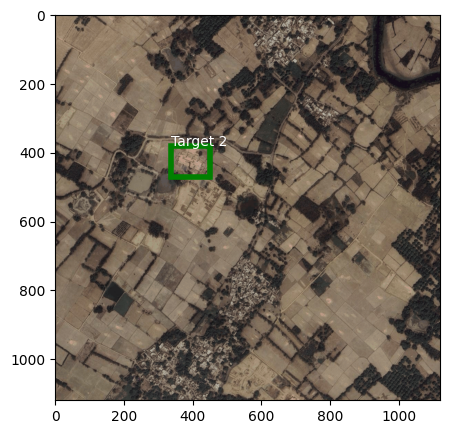

In [5]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target, pred = []):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(figsize = (5,5))
    a.imshow(img)
    for box, label in zip((target['boxes'].cpu()),target['labels'].cpu()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 4,
                                 edgecolor = 'g',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        rx,ry = rect.get_xy()
        a.annotate(f'Target {label}', (rx,ry), color = 'white')
        
    if len(pred):
        for box, label in zip(pred['boxes'].cpu(), pred['labels'].cpu()):
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = patches.Rectangle((x, y),
                                    width, height,
                                    linewidth = 2,
                                    edgecolor = 'r',
                                    facecolor = 'none')

            # Draw the bounding box on top of the image
            a.add_patch(rect)
            rx, ry =rect.get_xy()
            a.annotate(f'Predicted {label}', (rx, ry + width), color = 'white')
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target, img_names = dataset[0]
plot_img_bbox(img, target)



In [6]:
def get_object_detection_model(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [7]:
# bbox_params to set the format of bounding boxes
def get_transform():
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# use our dataset and defined transformations
dataset = KilnsImageDataset(train_dir_imgs,annotations_dir, 1120, 1120, transforms= get_transform())

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, 
    num_workers=4,
    collate_fn= collate_fn)

print('Length of dataset:',len(dataset))

Length of dataset: 321


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3
model = get_object_detection_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Train

In [14]:
# training for 100 epochs
num_epochs = 100
train_loss = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    for imgs, annotations, img_name in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        # sum of all losses classifier + regressor loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    train_loss.append(epoch_loss)
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 12.363236427307129, time : 11.030018091201782
epoch : 2, Loss : 8.842109680175781, time : 9.819090127944946
epoch : 3, Loss : 8.20107364654541, time : 10.002882242202759
epoch : 4, Loss : 7.891269683837891, time : 10.561582326889038
epoch : 5, Loss : 6.951510906219482, time : 10.547680377960205
epoch : 6, Loss : 7.021548748016357, time : 10.299473524093628
epoch : 7, Loss : 6.225892066955566, time : 10.19987154006958
epoch : 8, Loss : 5.579112529754639, time : 9.954948663711548
epoch : 9, Loss : 5.5669755935668945, time : 10.005504846572876
epoch : 10, Loss : 5.458775520324707, time : 10.06968355178833
epoch : 11, Loss : 5.054272651672363, time : 9.948393106460571
epoch : 12, Loss : 3.938499689102173, time : 9.963354587554932
epoch : 13, Loss : 3.584970474243164, time : 9.938059568405151
epoch : 14, Loss : 3.4614672660827637, time : 10.314624071121216
epoch : 15, Loss : 2.920870304107666, time : 10.47239637374878
epoch : 16, Loss : 2.644150733947754, time : 10.1119346

[tensor(12.3632, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.8421, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.2011, device='cuda:0', grad_fn=<AddBackward0>), tensor(7.8913, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.9515, device='cuda:0', grad_fn=<AddBackward0>), tensor(7.0215, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.2259, device='cuda:0', grad_fn=<AddBackward0>), tensor(5.5791, device='cuda:0', grad_fn=<AddBackward0>), tensor(5.5670, device='cuda:0', grad_fn=<AddBackward0>), tensor(5.4588, device='cuda:0', grad_fn=<AddBackward0>), tensor(5.0543, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.9385, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.5850, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.4615, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.9209, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.6442, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4711, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1896, device='cuda:0

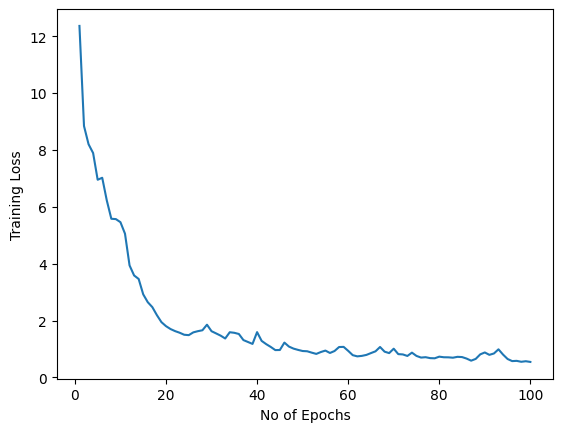

In [15]:
# Training loss curve
print(train_loss)
print(type(train_loss))
fig, ax = plt.subplots()
with torch.no_grad():  
    train_loss1 = [loss1.to(torch.device('cpu')) for loss1 in train_loss]
    print(train_loss1)
    ax.plot(range(1,num_epochs+1),train_loss1)
    ax.set_xlabel('No of Epochs')
    ax.set_ylabel('Training Loss')

In [16]:
num_epochs = 100
if google_static_images:
    torch.save(model.state_dict(),f'model_{num_epochs}_GSM_W_LKO_v3.pt')
else:
    torch.save(model.state_dict(),f'model_{num_epochs}_Sentinel_W_LKO_v3.pt')

In [11]:
num_epochs = 100
if google_static_images:
    model.load_state_dict(torch.load(f'model_{num_epochs}_GSM_W_LKO_v3.pt'))
else:
    model.load_state_dict(torch.load(f'model_{num_epochs}_Sentinel_W_LKO_v3.pt'))

Model performance evaluation

In [12]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [13]:
def make_prediction(model, img, score_threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > score_threshold : 
                idx_list.append(idx)
        # print(preds[id]['scores'],idx_list)
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

Target: {'boxes': tensor([[ 230.9008,    7.2785,  349.8477,  102.5888],
        [ 967.9938,  381.9643, 1087.1909,  484.3640],
        [ 637.7849,  708.2439,  721.6172,  818.5722]]), 'labels': tensor([1, 1, 2]), 'image_id': tensor(77)}
Prediction on train {'boxes': tensor([[ 638.1481,  707.2405,  721.3110,  815.6425],
        [ 230.5541,    7.9736,  350.2886,  100.6668],
        [ 969.7946,  381.6535, 1087.3972,  483.4180]], device='cuda:0'), 'labels': tensor([2, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9994, 0.9991], device='cuda:0')}


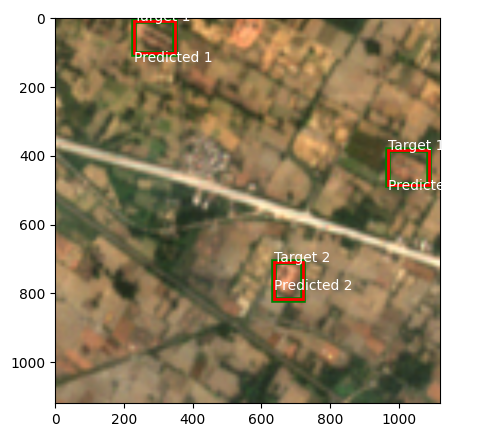

In [23]:
# prediction on training set and plotting for first batch.
with torch.no_grad():
    for imgs, annotations,img_name in data_loader:
        img = [im.to(device) for im in imgs]
        pred = make_prediction(model, img, score_threshold= 0.001)
        # pred = model(img)
        break

    id = 3
    img,target = imgs[id], annotations[id]
    print('Target:',target)
    print('Prediction on train',pred[id])
    plot_img_bbox(torch_to_pil(img), target, pred[id])


In [49]:
if google_static_images:
    test_annotations_dir = '/delhi_aa_v1/labels'
else:
    test_annotations_dir = '/wb_grid_400_aa_v1/labels'
dataset_test = KilnsImageDataset(test_dir_imgs,test_annotations_dir, 1120, 1120, transforms= get_transform())
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=True, 
    num_workers=4,
    collate_fn= collate_fn)


labels_test = []
preds_adj_all_test = []
annot_all_test = []
img_names_list = []

for im, annot, img_name in data_loader_test:
    im = list(img.to(device) for img in im)
    img_names_list += [name for name in img_name]
    for t in annot:
        labels_test += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, score_threshold= 0.001)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all_test.append(preds_adj)
        annot_all_test.append(annot)

In [50]:
# saving test set predictions to yolo format in a directory
from FasterRCNN_output_to_yolo_format import save_predictions
save_predictions('processed_data/high_res_v3_delhi', preds_adj_all_test,img_names_list,img_width=1120, img_height=1120)

In [43]:
with torch.no_grad():
    for imgs, annotations,img_names in data_loader_test:
        img = [im.to(device) for im in imgs]
        pred = make_prediction(model, img, score_threshold= 0.001)
        break
    for i in range(len(img)):
        id = i
        img, target = imgs[id], annotations[id]
        print(f'Target: {target}')
        print(f'Prediction : {pred[id]}')
        plot_img_bbox(torch_to_pil(img), target, pred[id])

